In this cycle we:

- Dropped some features to improve our model
- Defined each cluster profile
- EDA with cluster information


# 1 IMPORTS

In [1]:
import re
import inflection
import numpy                                          as np
import pandas                                         as pd
import sweetviz                                       as sv
import seaborn                                        as sns
import umap.umap_                                     as umap
import matplotlib.cm                                  as cm
import matplotlib.pyplot                              as plt
            
from plotly              import express               as px
from sklearn             import cluster               as c
from sklearn             import metrics               as m
from sklearn             import mixture               as mx
from IPython.display     import Image      
from sklearn             import ensemble              as en
from sklearn             import manifold              as mn
from sklearn             import decomposition         as dd
from sklearn             import preprocessing         as pp
from scipy.cluster       import hierarchy             as hc
from pandas_profiling    import ProfileReport
from sklearn.neighbors   import NearestNeighbors
from yellowbrick.cluster import KElbowVisualizer 
from yellowbrick.cluster import SilhouetteVisualizer

import warnings
warnings.filterwarnings('ignore')

## 1.1 Definitions 

In [2]:
# Set Seaborn configurations
sns.set_palette('tab10')
sns.set_style('darkgrid')

# Standard font for plots
def std_font(ax1, title, xlabel, ylabel):
    ax1.set_title(title, loc='left', fontdict={'fontsize': 18}, pad=20)
    ax1.set_xlabel(xlabel, fontdict={'fontsize': 12, 'style': 'italic'})
    ax1.set_ylabel(ylabel, fontdict={'fontsize': 12, 'style': 'italic'})
    return None

## 1.2 Loading Data

In [3]:
df_raw = pd.read_csv('../data/ecommerce.csv', parse_dates=['InvoiceDate'])
# Renaming columns
cols_snake = list( map( lambda x: inflection.underscore( x ), df_raw.columns ) )
df_raw.columns = cols_snake

# 2 DATA DESCRIPTION

## 2.1 Data Preview

In [4]:
df_raw.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850.0,United Kingdom


## 2.2 Data Format and Types

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    541909 non-null  object        
 1   stock_code    541909 non-null  object        
 2   description   540455 non-null  object        
 3   quantity      541909 non-null  int64         
 4   invoice_date  541909 non-null  datetime64[ns]
 5   unit_price    541909 non-null  float64       
 6   customer_id   406829 non-null  float64       
 7   country       541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## 2.3 NA Checking and Treatment

In [6]:
df_raw.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 2.3.1 Treating Missing Values

In [7]:
# adding 'No description' to missing discription
df_raw['description'].fillna(value='NO DESCRIPTION', inplace=True)

# creating customers_id
df_missing = df_raw.loc[df_raw['customer_id'].isna(), :]
df_not_missing = df_raw.loc[~df_raw['customer_id'].isna(), :]

df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)

# merge original with reference dataframe
df_raw = pd.merge(df_raw, df_backup, on='invoice_no', how='left')

# coalesce
df_raw['customer_id'] = df_raw['customer_id_x'].combine_first(
    df_raw['customer_id_y'])

# drop extra columns
df_raw = df_raw.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

In [8]:
df_raw.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
country         0
customer_id     0
dtype: int64

## 2.4 Changing types

In [9]:
df_raw['customer_id'] = df_raw['customer_id'].astype( int )

## 2.5 Discriptive Statistics

In [10]:
df_clean = df_raw.copy()

### 2.5.1 Numerical Attributes

Important findings:

- We found a huge negative value in quantitiy (that can be due to product return, or cancelled purchase)
- We found a zero minimum price (what is the root cause of this? promotions? coupons?)
- We found a lot of negative values in quantity

In [11]:
num_att = df_clean.select_dtypes(['int64', 'float64', 'int'])

In [12]:
# getting skew
skew = pd.DataFrame(num_att.apply(lambda x: x.skew())).round(2).T
skew.rename(index={0: 'skew'}, inplace=True)

# getting kurtosis
kurtosis = pd.DataFrame(num_att.apply(lambda x: x.kurtosis())).round(2).T
kurtosis.rename(index={0: 'kurtosis'}, inplace=True)

# numerical features 
describe = num_att.describe().round(2)
ma = pd.concat([describe, skew, kurtosis], axis=0)
ma

,quantity,unit_price,customer_id
count,541909.00,541909.00,541909.00
mean,9.55,4.61,16688.84
std,218.08,96.76,2911.41
min,-80995.00,-11062.06,12346.00
25%,1.00,1.25,14367.00
50%,3.00,2.08,16249.00
75%,10.00,4.13,18283.00
max,80995.00,38970.00,22709.00
skew,-0.26,186.51,0.49
kurtosis,119769.16,59005.72,-0.80


### 2.5.2 Categorical Attributes

In [13]:
cat_att = df_clean.select_dtypes(['object'])

In [14]:
cat_att.apply( lambda x: x.unique().shape[0] )

invoice_no     25900
stock_code      4070
description     4224
country           38
dtype: int64

In [15]:
df_letter_invoices = df_clean.loc[df_clean['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]
df_letter_invoices.head()

print( 'Total number of invoices: {}'.format( len( df_letter_invoices ) ) )
print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )

Total number of invoices: 9291
Total number of negative quantity: 9288


# 3 DATAFRAME FILTERING

## 3.1 Line Filtering

In [16]:
# filtering zero values in unit_price (WE WILL CONSIDER THESE ITEMS AS PROMO OR ERROR)
df_clean.query('unit_price >= 0.04 ', inplace=True)

# bad users (apresentam padroes de compra bastante desconexo, poluindo nosso modelo)
df_clean = df_clean[~df_clean['customer_id'].isin([16446])]

# Considering negative quantities as devolutions and positive quantities as real purchases
df_clean_returns = df_clean.query('quantity < 0')
df_clean = df_clean.query('quantity >=0')

# removing stock codes that does not represent puchases
df_clean = df_clean[~df_clean['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
                                                  'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# removing innacurate country information
df_clean = df_clean[~df_clean['country'].isin(
    ['European Community', 'Unspecified'])]

# 4 QUESTIONS & HYPOTHESIS

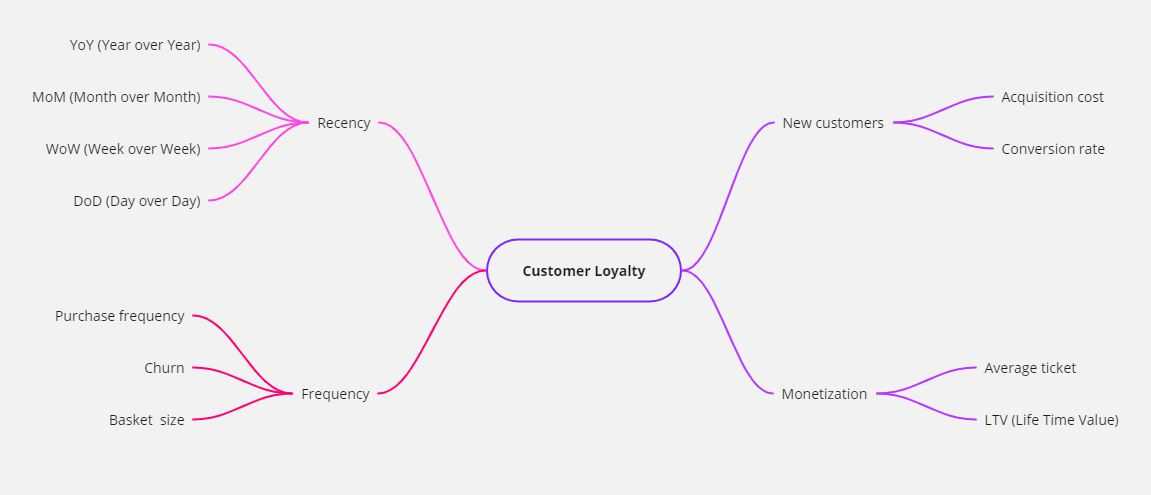

In [17]:
Image( '../images/mindmap.JPG' )

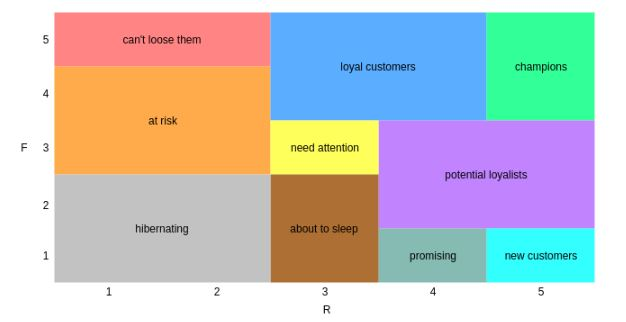

In [18]:
Image( '../images/rfm.JPG' )

Picture - https://medium.com/codex/crm-analytics-rfm-analysis-90aa2ae55fbc

**1.** 

**2.** 

**3.** 

**4.** 

**5.** 

**6.** 

**7.** 

**8.** 

# 5 FEATURE ENGINEERING

In [19]:
# ====================
# CREATING RFM TABLE
# ====================

# initiating df_rfm table with customers IDs
df_rfm = df_clean.drop( ['invoice_no', 'stock_code', 'description', 
                    'quantity', 'invoice_date', 'unit_price', 
                    'country'], axis=1 ).drop_duplicates( ignore_index=True )

## 5.1 Gross Revenue

In [20]:
# monetary
df_clean['gross_revenue'] = df_clean['quantity'] * df_clean['unit_price']
df_monetary = df_clean[['customer_id', 'gross_revenue']
                       ].groupby('customer_id').sum().reset_index()
df_rfm = pd.merge(df_rfm, df_monetary, on='customer_id', how='left')

## 5.2 Recency Days

In [21]:
# recency - last purchase
df_recency = df_clean[['customer_id', 'invoice_date']
                      ].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (
    df_clean['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_rfm = pd.merge(df_rfm, df_recency, on='customer_id', how='left')

## 5.3 Amount Invoices

In [22]:
# amount of purchases
df_freq = df_clean[['customer_id', 'invoice_no']].drop_duplicates().groupby(
    'customer_id').count().reset_index().rename(columns={'invoice_no': 'amount_invoices'})
df_rfm = pd.merge(df_rfm, df_freq, on='customer_id', how='left')

## 5.4 Amount Items

In [23]:
# amount of purchased items
df_prod = df_clean[['customer_id', 'quantity']].groupby(
    'customer_id').sum().reset_index().rename(columns={'quantity': 'amount_items'})
df_rfm = pd.merge(df_rfm, df_prod, on='customer_id', how='left')

## 5.5 Amount Products

In [24]:
# amount of purchased products
# Numero de produtos
df_freq = (df_clean.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                           .reset_index()
                                                           .rename( columns={'stock_code': 'amount_products'} ) )
df_rfm = pd.merge( df_rfm, df_freq, on='customer_id', how='left' )


## 5.6 Average Ticket

In [25]:
# average ticket
df_avg_ticket = df_clean[['customer_id', 'gross_revenue']].groupby(
    'customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_rfm = pd.merge(df_rfm, df_avg_ticket, on='customer_id', how='left')

## 5.7 Amount Returns

In [26]:
# number of returns
df_number_returns = df_clean_returns[['customer_id', 'quantity']].groupby(
    'customer_id').sum().reset_index().rename(columns={'quantity': 'amount_returns'})
df_number_returns['amount_returns'] = df_number_returns['amount_returns'] * -1
df_rfm = pd.merge(df_rfm, df_number_returns, on='customer_id', how='left')
df_rfm.loc[df_rfm['amount_returns'].isna(), 'amount_returns'] = 0
# df_rfm['amount_returns'].fillna(value=0, inplace=True)

## 5.8 Average Recency Days

In [27]:
# # Average recency days
# df_aux = df_clean[['customer_id', 'invoice_date']].drop_duplicates(
# ).sort_values(['customer_id', 'invoice_date'], ascending=[False, False])
# df_aux['next_customer_id'] = df_aux['customer_id'].shift()  # next customer
# df_aux['previous_date'] = df_aux['invoice_date'].shift()  # next invoince date
# df_aux['avg_recency_days'] = df_aux.apply(lambda x: (
#     x['invoice_date'] - x['previous_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1)
# df_aux = df_aux.drop(['invoice_date', 'next_customer_id',
#                      'previous_date'], axis=1).dropna()

# df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# df_rfm = pd.merge(df_rfm, df_avg_recency_days, on='customer_id', how='left')

## 5.9 Frequency

In [28]:
# frequency purchase
df_aux = (df_clean[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
          .groupby('customer_id')
          .agg(max_=('invoice_date', 'max'),
               min_=('invoice_date', 'min'),
               days_=('invoice_date', lambda x: (
                   (x.max() - x.min()).days) + 1),
               buy_=('invoice_no', 'count'))).reset_index()

df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(
    lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1)
df_rfm = pd.merge(
    df_rfm, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')

## 5.10 Average Basket Size

In [29]:
# basket size (Units by basket)
df_aux = (df_clean.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
          .agg(n_purchase=('invoice_no', 'nunique'),
               n_products=('quantity', 'sum'))
          .reset_index())

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_rfm = pd.merge(
    df_rfm, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id')

## 5.11 Average Unique Basket Size

In [30]:
df_aux = (df_clean.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
          .agg(n_purchase=('invoice_no', 'nunique'),
               n_products=('stock_code', 'nunique'))
          .reset_index())

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_rfm = pd.merge(df_rfm, df_aux[[
                  'customer_id', 'avg_unique_basket_size']], how='left', on='customer_id')

# 6 STATISTICAL ANALYSIS

In [31]:
df_rfm.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
amount_invoices           0
amount_items              0
amount_products           0
avg_ticket                0
amount_returns            0
frequency                 0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

In [32]:
df_rfm.dropna(inplace=True)

## 6.1 Report for Univariate Analysis

In [33]:
# profile = ProfileReport( df_rfm )
# profile.to_file( 'profile_report.html' )

## 6.2 Multivariate Analysis


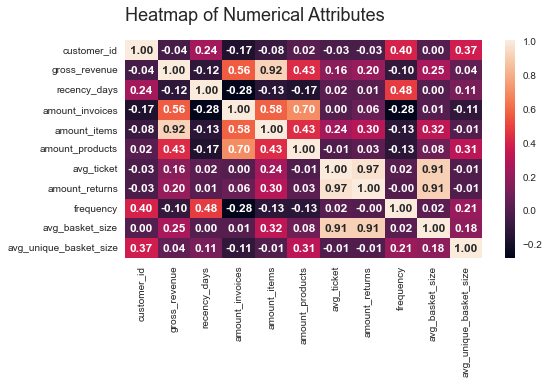

In [34]:
correlation = df_rfm.corr( method='pearson' )
plt.figure( figsize=(8, 4) )
ax1 = sns.heatmap(data=correlation, annot=True, fmt='.2f', annot_kws={'fontsize':12, 'fontweight':'bold'})
std_font(ax1, 'Heatmap of Numerical Attributes', '', '')

# 7 FEATURE SELECTION

In [35]:
df_rfm_raw = df_rfm.copy()
selected_cols = ['customer_id', 'gross_revenue', 'recency_days', 'amount_products', 'frequency', 'amount_returns']
df_rfm = df_rfm[selected_cols].copy()

# 8 DATA PREPARATION

## 8.1 Normalization

In [36]:
## Standard Scalaer
mm = pp.MinMaxScaler()

df_rfm['gross_revenue']    = mm.fit_transform( df_rfm[['gross_revenue']] )
df_rfm['recency_days']     = mm.fit_transform( df_rfm[['recency_days']] )
df_rfm['amount_products']  = mm.fit_transform( df_rfm[['amount_products']])
df_rfm['frequency']        = mm.fit_transform( df_rfm[['frequency']])
df_rfm['amount_returns']   = mm.fit_transform( df_rfm[['amount_returns']])

In [37]:
X = df_rfm.drop(columns=['customer_id']).copy()
X.head()

,gross_revenue,recency_days,amount_products,frequency,amount_returns
0,0.019312,0.997319,0.037770,1.000000,0.000539
1,0.011579,0.150134,0.021692,0.001345,0.000485
2,0.024020,0.005362,0.029476,0.002052,0.000687
3,0.003396,0.254692,0.003445,0.000734,0.000000
4,0.003137,0.892761,0.000255,0.003985,0.000296


## 8.2 Space Study

### 8.2.1 PCA

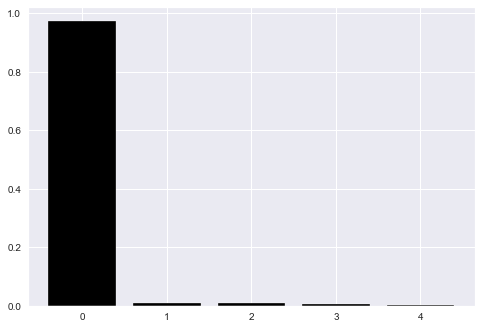

In [38]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )

# pca component
df_pca = pd.DataFrame( principal_components )

### 8.2.2 UMAP

In [39]:
reducer = umap.UMAP( n_components=4, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]
df_umap['embedding_z'] = embedding[:, 2]
df_umap['embedding_w'] = embedding[:, 3]
# df_umap['embedding_u'] = embedding[:, 4]

# # plot UMAP
# sns.scatterplot( x='embedding_x', 
#                  y='embedding_y', 
#                  data=df_umap )

### 8.2.3 t-SNE

In [40]:
reducer = mn.TSNE( n_components=3, n_jobs=-1, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]
df_tsne['embedding_z'] = embedding[:, 2]

# # plot UMAP
# sns.scatterplot( x='embedding_x', 
#                  y='embedding_y', 
#                  data=df_tsne )

### 8.2.4 TREE Based Embedding

In [41]:
# training dataset
X = df_rfm.drop( columns=['customer_id', 'gross_revenue'], axis=1 )
y = df_rfm['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model training
rf_model.fit( X, y )

# Leaf 

# dataframe Leaf

df_leaf = pd.DataFrame( rf_model.apply( X ) )

# Reduzer dimensionality
reducer = umap.UMAP(n_components=5, random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]
df_tree['embedding_z'] = embedding[:, 2]
df_tree['embedding_w'] = embedding[:, 3]
df_tree['embedding_u'] = embedding[:, 4]

# # plot UMAP
# sns.scatterplot( x='embedding_x', 
#                  y='embedding_y', 
#                  data=df_tree )

In [42]:
# # Saving the embedded space
# df_tree.to_csv('../data/embedded_space.csv', index=False)

# 9 CHOSEN MODEL

In [43]:
# Using Embedded Space
X = df_umap.copy() 

In [44]:
# model definition
k = 8
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

# model training
kmeans.fit( X )

# clustering
labels = kmeans.labels_

In [45]:
df_eda = X.copy()
df_eda['cluster'] = labels
df_rfm_raw['cluster'] = labels

In [46]:
## WSS ( Within-cluster sum of square)
print( 'WSS value: {}'.format( kmeans.inertia_ ) )

## SS ( Silhouette Score )
print( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

WSS value: 97056.125
SS value: 0.5443276166915894


# 10 BUSINESS PERFORMANCE

In [47]:
df_cluster_embed = X.copy()
df_cluster_embed['cluster'] = labels
df_cluster_embed.head()

,embedding_x,embedding_y,embedding_z,embedding_w,cluster
0,-3.029993,9.952247,8.345515,1.701905,4
1,13.304445,13.189207,8.327514,8.831138,6
2,11.384762,9.170521,15.499040,-3.444309,3
3,10.469833,7.522410,7.934718,10.154498,6
4,8.770447,-0.304306,8.852541,13.856702,6


In [48]:
# sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', data=df_cluster_embed, palette='deep')

## 10.1 Final Dataframe With Clusters

In [49]:
# Number of customer
df_cluster = df_rfm_raw[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df_rfm_raw[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df_rfm_raw[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg products_no
df_invoice_no = df_rfm_raw[['amount_products', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )

# Frequency
df_invoice_no = df_rfm_raw[['frequency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )

# Returns
df_invoice_no = df_rfm_raw[['amount_returns', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )

# df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,amount_products,frequency,amount_returns
0,0,436,7.655838,526.068372,258.018349,43.208716,1.018349,1.360092
1,1,508,8.920105,614.771890,71.114173,46.501969,1.058024,6.198819
2,2,452,7.936787,970.335310,20.681416,80.353982,0.998709,1.283186
3,3,1838,32.273924,3717.091970,18.852013,163.760609,0.039972,42.933079
4,4,277,4.863916,906.624801,362.581227,65.126354,1.051473,2.490975
5,5,356,6.251097,857.132837,311.974719,63.997191,1.005618,210.376404
6,6,916,16.084284,1231.994727,129.581878,62.990175,0.034100,22.239083
7,7,912,16.014047,666.228388,156.894737,53.854167,1.019737,3.419956


In [50]:
df_cluster.style.highlight_max(subset=['gross_revenue', 'amount_products', 'frequency'], color='lightgreen', axis=0 )\
.highlight_min(subset=['recency_days', 'amount_returns'], color='lightgreen', axis=0 )\
.highlight_max(subset=['recency_days', 'amount_returns'], color='pink', axis=0 )\
.highlight_min(subset=['gross_revenue', 'amount_products', 'frequency'], color='pink', axis=0 )

,cluster,customer_id,perc_customer,gross_revenue,recency_days,amount_products,frequency,amount_returns
0,0,436,7.655838,526.068372,258.018349,43.208716,1.018349,1.360092
1,1,508,8.920105,614.771890,71.114173,46.501969,1.058024,6.198819
2,2,452,7.936787,970.335310,20.681416,80.353982,0.998709,1.283186
3,3,1838,32.273924,3717.091970,18.852013,163.760609,0.039972,42.933079
4,4,277,4.863916,906.624801,362.581227,65.126354,1.051473,2.490975
5,5,356,6.251097,857.132837,311.974719,63.997191,1.005618,210.376404
6,6,916,16.084284,1231.994727,129.581878,62.990175,0.034100,22.239083
7,7,912,16.014047,666.228388,156.894737,53.854167,1.019737,3.419956


Cluster A: 
- Number of customers: 1838 (32.3% of customers )
- Average Recency: 18.8 days
- Average invoice_no: 163.7 
- Average Gross Revenue: U\$3,717.10
- Average purchases/day: 0.04
- Average products return: 42.9

Cluster B:
- Number of customers: 916 (16% of customers )
- Average Recency: 129.6 days
- Average invoice_no: 63
- Average Gross Revenue: U\$1,231.99
- Average purchases/day: 0.03
- Average products return: 22.2

Cluster C:
- Number of customers: 452 (7.9% of customers )
- Average Recency: 20.68 days
- Average invoice_no: 80.35 
- Average Gross Revenue: U\$970.33
- Average purchases/day: 0.99
- Average products return: 1.28

Cluster D:
- Number of customers: 277 (4.86% of customers )
- Average Recency: 362.58 days
- Average invoice_no: 65.1 
- Average Gross Revenue: U\$906.60
- Average purchases/day: 1.05
- Average products return: 2.49

Cluster E:
- Number of customers: 356 (6.25% of customers )
- Average Recency: 312 days
- Average invoice_no: 64 
- Average Gross Revenue: U\$857.13
- Average purchases/day: 1
- Average products return: 210.4

Cluster F:
- Number of customers: 912 (16% of customers )
- Average Recency: 157 days
- Average invoice_no: 53.8 
- Average Gross Revenue: U\$666.2
- Average purchases/day: 1
- Average products return: 3.4

Cluster G:
- Number of customers: 508 (8.9% of customers )
- Average Recency: 71.11 days
- Average invoice_no: 46.5 
- Average Gross Revenue: U\$614.77
- Average purchases/day: 1
- Average products return: 6.2

Cluster H:
- Number of customers: 436 (7.65% of customers )
- Average Recency: 258 days
- Average invoice_no: 43 
- Average Gross Revenue: U\$526.00
- Average purchases/day: 1
- Average products return: 1.3